# LightGBM

- [docs](https://lightgbm.readthedocs.io/en/latest/index.html)

In [1]:
import pandas as pd햣
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


## 1. Data Load

In [2]:
data_dir = './data/' 
csv_file_path = os.path.join(data_dir, 'train_data_3PL.csv')
df = pd.read_csv(csv_file_path)
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Dffclt,Dscrmn,Gussng
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,-2.017182,20.079513,0.052178
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,-1.723821,4.616495,0.056888
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,-0.167255,18.583456,0.754422
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.496282,39.877030,0.946875
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,-1.335100,6.965071,0.237969


## 2. Feature Engineering

In [3]:
import pandas as pd

def feature_engineering(df):

    # 유저별로 정렬
    df.sort_values(by=['userID', 'Timestamp'], inplace=True)
    
    # 데이터 타입 변경
    dtype = {
        'userID': 'int16',
        'answerCode': 'int8',
        'KnowledgeTag': 'int16'
    }
    df = df.astype(dtype)
    
    # 'Timestamp' 열을 날짜/시간 형식으로 파싱
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')

    # testTag 추가
    df['testTag'] = df['testId'].apply(lambda x: x[2]).astype('int16')

    # 유저별로 정답 누적 횟수 계산, 결측치 0
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_correct_answer'].fillna(0, inplace=True)
    
    # 유저별로 제출 누적 횟수 계산
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount() 
    
    # 유저별로 누적 정답률 계산, 결측치 0.75
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    df['user_acc'].fillna(0.75, inplace=True)

    # userID별 정답률 추가
    df['user_sum'] = df.groupby('userID')['answerCode'].transform('sum')
    df['user_mean'] = df.groupby('userID')['answerCode'].transform('mean')
    
    # assessmentItemID별 정답률 추가
    df['assessment_sum'] = df.groupby('assessmentItemID')['answerCode'].transform('sum')
    df['assessment_mean'] = df.groupby('assessmentItemID')['answerCode'].transform('mean')
    
    # testId별 정답률 추가
    df['test_sum'] = df.groupby('testId')['answerCode'].transform('sum')
    df['test_mean'] = df.groupby('testId')['answerCode'].transform('mean')
    
    # KnowledgeTag별 정답률 추가
    df['knowledgeTag_sum'] = df.groupby('KnowledgeTag')['answerCode'].transform('sum')
    df['knowledgeTag_mean'] = df.groupby('KnowledgeTag')['answerCode'].transform('mean')
    
    # testTag별 정답률 추가
    df['testTag_sum'] = df.groupby('testTag')['answerCode'].transform('sum')
    df['testTag_mean'] = df.groupby('testTag')['answerCode'].transform('mean')

    # 상대적 정답률
    df['relative_answer_assessment'] = df['answerCode'] - df.groupby('assessmentItemID')['answerCode'].transform('mean')
    
    # 유저별 상대적 정답률 평균 - 학습 수준 레벨
    df['relative_answer_mean'] = df.groupby('userID')['relative_answer_assessment'].transform('mean')

    # 유저가 문항을 푼 시간
    df['time_to_solve'] = df.groupby(['userID', 'testId'])['Timestamp'].diff().dt.total_seconds().shift(-1)
    
    # 결측치 이전 행의 값으로 채움
    df['time_to_solve'].fillna(method='ffill', inplace=True)

    # 유저별 문항 시간 평균
    #df['time_to_solve_mean'] = df.groupby('userID')['time_to_solve'].transform('mean')
    df['time_to_solve_mean'] = df.groupby(['userID', 'testId'])['time_to_solve'].transform('mean')

    # clip(0, 255)는 메모리를 위해 uint8 데이터 타입을 쓰기 위함
    df['prior_assessment_frequency'] = df.groupby(['userID', 'assessmentItemID']).cumcount().clip(0, 255)

    # 각 태그별로 이전에 몇번 풀었는지
    df['prior_KnowledgeTag_frequency'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()
    
    # 시험지 태그별 학년별 몇번 풀었는지
    df['prior_testTag_frequency'] = df.groupby(['userID', 'testTag']).cumcount()
    
    return df


In [4]:
df = feature_engineering(df)

/var/folders/8r/strv9f_x6b3ghnb0chcl145m0000gn/T/ipykernel_2232/21048499.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_to_solve'].fillna(method='ffill', inplace=True)


In [5]:
data_types = df.dtypes
print(data_types)

userID                                   int16
assessmentItemID                        object
testId                                  object
answerCode                                int8
Timestamp                       datetime64[ns]
KnowledgeTag                             int16
Dffclt                                 float64
Dscrmn                                 float64
Gussng                                 float64
testTag                                  int16
user_correct_answer                    float64
user_total_answer                        int64
user_acc                               float64
user_sum                                 int64
user_mean                              float64
assessment_sum                           int64
assessment_mean                        float64
test_sum                                 int64
test_mean                              float64
knowledgeTag_sum                         int64
knowledgeTag_mean                      float64
testTag_sum  

## 3. Train/Test 데이터 셋 분리

In [6]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함

random.seed(42)

def custom_train_test_split(df, ratio=0.7, split=True):
    # df: 입력 데이터프레임
    # ratio: 학습 데이터의 비율, 기본값은 0.7
    # split: True로 설정할 경우 테스트 데이터를 반환, False로 설정할 경우 학습 데이터를 반환

    # 사용자(UserID) 아이디와 해당 유저의 데이터 개수를 튜플로 묶어 리스트로 만듭니다.
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    
    # 유저 리스트를 무작위로 shuffle
    random.shuffle(users)

    # 학습용 데이터의 최대 길이를 계산(ratio), 1586610.2
    max_train_data_len = ratio*len(df) 

    # 학습용 데이터의 누적 개수와 학습에 사용할 유저 아이디를 저장할 변수 초기화
    sum_of_train_data = 0   # 1586711

    # 학습에 사용할 user_id 를 리스트에 추가
    user_ids =[]            # 4669 유저
    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data: # 학습 데이터의 누적 개수가 최대 길이를 초과하면 루프를 종료
            break
        user_ids.append(user_id) 

    # 학습용 데이터로 사용할 user_id 에 해당하는 데이터를 선택하여 train에 할당 합니다.
    train = df[df['userID'].isin(user_ids)]

    # 테스트 데이터로 사용할 user_id 에 해당하는 데이터를 선택하여 test에 할당합니다.
    test = df[df['userID'].isin(user_ids) == False]
    
    # test 데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [7]:
train, test = custom_train_test_split(df)

In [8]:
df.columns.tolist()

['userID',
 'assessmentItemID',
 'testId',
 'answerCode',
 'Timestamp',
 'KnowledgeTag',
 'Dffclt',
 'Dscrmn',
 'Gussng',
 'testTag',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
 'user_sum',
 'user_mean',
 'assessment_sum',
 'assessment_mean',
 'test_sum',
 'test_mean',
 'knowledgeTag_sum',
 'knowledgeTag_mean',
 'testTag_sum',
 'testTag_mean',
 'relative_answer_assessment',
 'relative_answer_mean',
 'time_to_solve',
 'time_to_solve_mean',
 'prior_assessment_frequency',
 'prior_KnowledgeTag_frequency',
 'prior_testTag_frequency']

In [9]:
# 3pl 포함 피쳐 13개

FEATS = [
#  'userID',
#  'assessmentItemID',
#  'testId',
#  'answerCode',
#  'Timestamp',
 'KnowledgeTag',
 'Dffclt',
 'Dscrmn',
 'Gussng',
 'testTag',
 'user_correct_answer',
 'user_total_answer',
 'user_acc',
#  'user_sum',
 'user_mean',
#  'assessment_sum',
#  'assessment_mean',
#  'test_sum',
#  'test_mean',
#  'knowledgeTag_sum',
#  'knowledgeTag_mean',
#  'testTag_sum',
#  'testTag_mean',
#  'relative_answer_assessment',
 'relative_answer_mean',
 'time_to_solve',
 'time_to_solve_mean',
#  'prior_assessment_frequency',
#  'prior_KnowledgeTag_frequency',
 'prior_testTag_frequency'
 ]

In [10]:
# 'answerCode' 열을 따로 추출하여 타겟 변수로 저장합니다.
y_train = train['answerCode']

# 'answerCode' 열을 제거하여 학습 데이터의 피쳐들만 남깁니다.
train = train.drop(['answerCode'], axis=1)

# 테스트 데이터에서 'answerCode' 열을 따로 추출하여 테스트 데이터의 타겟 변수로 저장합니다.
y_test = test['answerCode']

# 테스트 데이터에서도 'answerCode' 열을 제거하여 피쳐들만 남깁니다.
test = test.drop(['answerCode'], axis=1)

# LightGBM 모델에 사용할 학습 데이터, 테스트를 lgb.Dataset 형식으로 변환합니다.
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)


## 4. 훈련 및 검증

In [11]:
model = lgb.train(
    {'objective': 'binary'},
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=500,                #  Number of boosting iterations.
    )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3070
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
VALID AUC : 0.8151262174517988 ACC : 0.7458893871449925



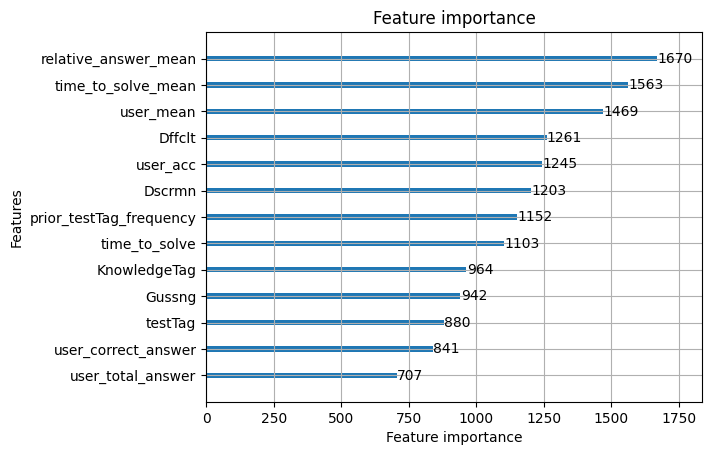

In [12]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [13]:
# LOAD TESTDATA
data_dir = './data/'
test_csv_file_path = os.path.join(data_dir, 'test_data_3PL.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

/var/folders/8r/strv9f_x6b3ghnb0chcl145m0000gn/T/ipykernel_2232/21048499.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['time_to_solve'].fillna(method='ffill', inplace=True)


In [14]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [15]:
# SAVE OUTPUT
output_dir = 'output_LightGBM/'
write_path = os.path.join(output_dir, "submission_LightGBM_3pl_f13.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output_LightGBM/submission_LightGBM_f13.csv


---
